<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_Price_prediction_part2/blob/master/3_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [36]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 8.2 MB 10.3 MB/s 


In [37]:
!pip install -U pymorphy2-dicts-ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
path_data = '/content/drive/MyDrive/SF_project_8/data/'

##Библиотеки

In [40]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import pymorphy2 

In [14]:
pd.set_option('display.float_format', '{:.2f}'.format)

SEED = 73

## Загрузка и подготовка данных для обучения

In [15]:
df_train = pd.read_csv(path_data+'train_for_ML.csv')
df_test = pd.read_csv(path_data+'test_for_ML.csv')

In [16]:
# Списки с признаками

categorical_features = ['bodyType', 'brand', 'color_littel', 'fuelType_littel', 'model_info',
                        'vehicleTransmission', 'ПТС', 'Привод', ]

numerical_features = ['mileage', 'age_avto', 'engineDisplacement', 'enginePower_log', 'numberOfDoors', 'Владельцы']

text_features = ['description']

target = 'price'
target_log = 'price_log'

In [17]:
# Добавим признак - разделитель для обучающего и тестового датасета 
df_train['sample'] = 1
df_test['sample'] = 0
df_test['price'] = 0

In [18]:
# объединим данные в один датасет для совместной дообработки признаков
df_join = pd.concat([df_train[numerical_features + categorical_features + text_features + [target, 'sample'] ],
                     df_test[numerical_features + categorical_features + text_features + [target, 'sample'] ]])

In [19]:
df_join.head(3)

,mileage,age_avto,engineDisplacement,enginePower_log,numberOfDoors,Владельцы,bodyType,brand,color_littel,fuelType_littel,model_info,vehicleTransmission,ПТС,Привод,description,price,sample
0,245000,14,3.00,5.61,4,3,седан,BMW,чёрный,бензин,5ER,автоматическая,Оригинал,полный,Авто на бодром ходу. Все работает отлично. П...,599000.00,1
1,183000,10,2.80,5.32,4,2,седан,AUDI,серый,бензин,A6,вариатор,Оригинал,передний,"Продажа от собственника, второй владелец, ПТС ...",850000.00,1
2,122733,8,3.50,5.72,4,3,седан,MERCEDES,чёрный,бензин,E_KLASSE,автоматическая,Оригинал,полный,Внимание! Только для клиентов AVILON Автомобил...,1325000.00,1


## Работа с текстом в колонке description

In [24]:
df_join.description.iloc[15]

'。Преднатяжители ремней безопасности\n。Крепление для детского сиденья ISOFIX\n。Подушка безопасности пассажира с функцией деактивации\n。Система динамической регулировки тяги\n。Система контроля давления в шинах\n。Безопасные шины Runflat\n。Рекуперация энергии торможения\n。Обивка салона - Кожа Dakota\n。Автоматическая коррекция угла наклона фар\n。Функция Auto Start Stop\n。Кнопка запуска/остановки двигателя\n。Сервотроник\n。Передние и задние парктроники\n。Обогрев боковых зеркал\n。Радио BMW Professional CD (CD-проигрыватель,Поддержка MP3, 8 и более динамиков,Многофункциональный цветной дисплей)\n。Разъем для подключения внешнего аудиоустройства\n。Навигационная система с жестким диском\n。Коммуникационная система Bluetooth\n\n☛ Все заявленные автомобили находятся в наличии.\n☛ Два комплекта ключей.\n☛ Выгода по программе Trade-In до 70 тысяч рублей.\n☛ Выгода в кредит до 80 тысяч рублей.\n\n\n▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼\n\n                       Условия при покупке автомобиля в кредит:\n\n➥ С

В данных куча мусор. С помощью регулярных выражений оставим только слова, состоящие из 3 и более букв. 

In [94]:
df_join['text'] = df_join['description'].apply(lambda s: re.sub(r'\d+', '', s))
df_join['text'] = df_join['text'].apply(lambda s: re.split(r'\W+', s))


In [95]:
# приведемм слова разммером более 2 букв к леммам 

morph = pymorphy2.MorphAnalyzer()

def lem(x):
    x = [morph.parse(w)[0].normal_form for w in x if len(w)>1 ]
    return x

df_join['text_lem'] = df_join['text'].apply(lem)

In [96]:
# посчитаем количество уникальных слов и частоту встречаемости каждого слова

count_words = {}

for i in range(df_join.shape[0]):
    text = df_join['text_lem'].iloc[i]

    for el in text:
        if el in count_words.keys():
            count_words[el] += 1
        else:
            count_words[el] = 1

In [97]:
# Создадим датафрейм частотности слов, учтоб удобно проанализировать какие сова можно убрать

df_words = pd.DataFrame(count_words, index = ['count']).T

In [98]:
print(f'Всего {df_words.shape[0]} уникальный слов от 2-х букв и более')

Всего 17947 уникальный слов от 2-х букв и более


In [99]:
# Из них тех, которые встречаюстя 1-3 раза. 

df_words[df_words['count']<=3]['count'].value_counts()

1    8292
2    2159
3    1028
Name: count, dtype: int64

In [100]:
# Особо часто встречающиеся
df_words[df_words['count']>4000]

,count
на,15600
всё,6349
по,10043
не,10673
салон,5959
задний,6250
от,4198
состояние,5270
год,5322
для,4927


In [101]:
# Список слов для обучения с частотой встречаемостии более 3-х раз
word_for_train = list(df_words[df_words['count']>3].index)

In [102]:
# Удалим редко встречающиеся слова

def word_train(x):
    new_list_word = []
    for el in x:
        if el in word_for_train:
            new_list_word.append(el)
    return new_list_word

df_join['text_lem_train'] = df_join['text_lem'].apply(word_train)

In [33]:
df_join['text'].iloc[15]

['',
 'Преднатяжители',
 'ремней',
 'безопасности',
 'Крепление',
 'для',
 'детского',
 'сиденья',
 'ISOFIX',
 'Подушка',
 'безопасности',
 'пассажира',
 'с',
 'функцией',
 'деактивации',
 'Система',
 'динамической',
 'регулировки',
 'тяги',
 'Система',
 'контроля',
 'давления',
 'в',
 'шинах',
 'Безопасные',
 'шины',
 'Runflat',
 'Рекуперация',
 'энергии',
 'торможения',
 'Обивка',
 'салона',
 'Кожа',
 'Dakota',
 'Автоматическая',
 'коррекция',
 'угла',
 'наклона',
 'фар',
 'Функция',
 'Auto',
 'Start',
 'Stop',
 'Кнопка',
 'запуска',
 'остановки',
 'двигателя',
 'Сервотроник',
 'Передние',
 'и',
 'задние',
 'парктроники',
 'Обогрев',
 'боковых',
 'зеркал',
 'Радио',
 'BMW',
 'Professional',
 'CD',
 'CD',
 'проигрыватель',
 'Поддержка',
 'MP3',
 '8',
 'и',
 'более',
 'динамиков',
 'Многофункциональный',
 'цветной',
 'дисплей',
 'Разъем',
 'для',
 'подключения',
 'внешнего',
 'аудиоустройства',
 'Навигационная',
 'система',
 'с',
 'жестким',
 'диском',
 'Коммуникационная',
 'система',


In [35]:
df_join['text'].values

array([list(['Авто', 'на', 'бодром', 'ходу', 'Все', 'работает', 'отлично', 'По', 'электрике', 'ходовой', 'АКПП', 'ДВС', 'нареканий', 'нет', 'Масло', 'не', 'ест', 'Салон', 'ухожен', 'На', 'запчасти', 'денег', 'не', 'жалел', 'Жидкости', 'все', 'поменял', 'Крашена', 'одна', 'дверь', 'левая', 'задняя', 'Штрафов', 'и', 'ограничений', 'нет', 'Торг', 'при', 'осмотре', 'Возможен', 'обмен', 'на', 'внедорожник', 'или', 'коммерческий', 'транспорт', '']),
       list(['Продажа', 'от', 'собственника', 'второй', 'владелец', 'ПТС', 'оригинал', 'Отличное', 'состояние', 'вложений', 'не', 'требует', 'Комплект', 'новой', 'зимней', 'резины', 'Nokian', 'По', 'кузову', 'мелкие', 'притертости', 'В', 'базе', 'бьется', 'как', '2', 'ДТП', 'т', 'к', 'все', 'зарегистрировано', 'в', 'ГИБДД', 'Обслуживание', 'только', 'у', 'официального', 'дилера', 'сервисная', 'книжка', 'в', 'наличии', 'Пройдено', 'ТО', 'Все', 'ключи', 'Эксплуатация', 'с', '2012', 'года', 'Хорошая', 'комплектация', 'дополнительное', 'оборудование'

## Работа с категориальными переменнаями

In [51]:
df_join = pd.get_dummies(df_join, columns=categorical_features, dummy_na=False)


## Разбиение датасета на обучающий, валидационный и тестовый

In [53]:
X = df_join.query('sample == 1').drop(['sample'], axis=1)
X_test = df_join.query('sample == 0').drop(['sample'], axis=1)

Y = X.price.values     # наш таргет
X = X.drop(['price'], axis=1)
X_test = X_test.drop(['price'], axis=1)

In [54]:
# Стандартизируем числовые данные

scaler = MinMaxScaler()

X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

In [55]:
X.describe()

,mileage,age_avto,engineDisplacement,enginePower_log,numberOfDoors,Владельцы,bodyType_внедорожник,bodyType_кабриолет,bodyType_купе,bodyType_купе-хардтоп,...,model_info_Z8,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,ПТС_Дубликат,ПТС_Оригинал,Привод_задний,Привод_передний,Привод_полный
count,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,...,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00
mean,0.12,0.21,0.42,0.54,0.76,0.55,0.35,0.01,0.06,0.01,...,0.00,0.79,0.05,0.02,0.14,0.11,0.89,0.27,0.11,0.63
std,0.08,0.13,0.16,0.18,0.29,0.42,0.48,0.08,0.24,0.12,...,0.01,0.41,0.22,0.14,0.35,0.31,0.31,0.44,0.31,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.06,0.11,0.30,0.42,0.67,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
50%,0.11,0.18,0.42,0.53,0.67,0.50,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
75%,0.17,0.29,0.45,0.66,1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [56]:
X_test.describe()

,mileage,age_avto,engineDisplacement,enginePower_log,numberOfDoors,Владельцы,bodyType_внедорожник,bodyType_кабриолет,bodyType_купе,bodyType_купе-хардтоп,...,model_info_Z8,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,ПТС_Дубликат,ПТС_Оригинал,Привод_задний,Привод_передний,Привод_полный
count,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,...,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00
mean,0.12,0.21,0.42,0.44,0.75,0.55,0.35,0.01,0.07,0.01,...,0.00,0.78,0.05,0.03,0.14,0.10,0.90,0.28,0.10,0.62
std,0.08,0.14,0.16,0.19,0.30,0.41,0.48,0.08,0.25,0.11,...,0.00,0.42,0.21,0.17,0.35,0.30,0.30,0.45,0.30,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.06,0.11,0.30,0.31,0.67,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
50%,0.11,0.18,0.41,0.43,0.67,0.50,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
75%,0.17,0.29,0.45,0.57,1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [57]:
# Разбиваем на обучающую и валидационную выборки
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=SEED, shuffle=True)

## Работа с изображениями

## Обучение модели

In [58]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [69]:
# создаем модель
model = Sequential([Dense(512, input_dim=X_train.shape[1], activation="relu"),
                    Dropout(0.5),
                    BatchNormalization(), 
                    Dense(256, activation="relu"),
                    Dropout(0.5),
                    Dense(1, activation="linear")])


In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 512)               81920     
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                      

In [71]:
optimizer = Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [72]:
checkpoint = ModelCheckpoint(path_data +'/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [73]:
history = model.fit(X_train, Y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_valid, Y_valid),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

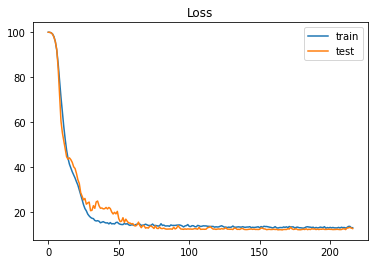

In [74]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();


In [75]:
model.load_weights(path_data +'/best_model.hdf5')
#model.save('../working/nn_1.hdf5')

In [76]:
y_valid_predict = model.predict(X_valid)
print(f"TEST mape: {(mean_absolute_percentage_error(Y_valid, y_valid_predict[:,0]))*100:0.2f}%")

TEST mape: 12.60%


In [ ]:
stop

## Предсказание

In [77]:
# предсказываем результат 
y_test_predict = model.predict(X_test)

In [78]:
y_test_predict

array([[ 425103.62],
       [2201827.5 ],
       [ 615394.25],
       ...,
       [1407742.6 ],
       [ 997804.75],
       [1079846.1 ]], dtype=float32)

In [ ]:
#y_test_predict = np.exp(y_test_predict)

In [79]:
submission = pd.read_csv(path_data+'sample_submission.csv')
submission['price'] = y_test_predict
submission.to_csv(path_data+'sample_submission_neural_network.csv', index=False)

In [80]:
submission

,sell_id,price
0,1099427284,425103.62
1,1096405886,2201827.50
2,1100195294,615394.25
3,1099827282,444452.44
4,1100076198,2572648.25
...,...,...
1666,1099414488,787154.19
1667,1099277058,2526036.25
1668,1098773964,1407742.62
1669,1098835932,997804.75
